#### Imaging Methods in Granular & Complex Fluids
# Day 4: Particle displacement & velocities

Karen Daniels, Distinguished Professor of Physics, NC State University kdaniel@ncsu.edu

Visiting Fulbright-Nehru Scholar, IISc Civil Engineering, September 2023 to January 2024

## Learning objectives

* Distinguish between Lagrangian and Eulerian measurements
* Demonstrate data input/output (I/O) techniques:
    - Download an unpack `.zip` files 
    - Load a sequence of images from the frames of a movie
    - Read data into arrays from text files
* Work with published data from an online repository
* Understand how measuring image correlations provides a velocity (displacement) vector field
* Understand how connecting nearby centroids provides particle trajectories & thereby particle velocities and granular temperature as well 
* Explore ways to improve accuracty and precision


# Pre-class

* *Pre-class reading:* Section 2.4.1 of Shattuck, M. D. Chapter 2: Experimental Techniques. Handbook of Granular Materials. CRC Press (2016)  (PDF is saved in GDrive)
* *Bring to class:* laptop with anaconda with `scipy`, `matplotlib`, and `scikit-image` installed, photos of particles (circular or otherwise); smartphone camera to take some short video clips, a while piece of paper
* *Install*: If possible, install the `imageio-ffmpeg` package inside Anaconda (https://anaconda.org/conda-forge/imageio-ffmpeg) and/or the ``ffmpeg`` program on your computer https://www.ffmpeg.org/ 


# In-Class

## Brainstorm with your neighbors

* if you've heard the terms: what do the terms *Eulerian* and *Lagrangian* mean to you?
* what are the pros/cons of measuring velocity or displacement fields, vs. tracking the motions of individual particles?
* which type of measurement do you think go into Bangalore traffic reports? how would you monitor traffic with the other one?
* what's different (or not) if you measure velocities (like a fluid, strain rate) vs. displacements (like a solid, strain)?

*space to write your thoughts ...*

## Load the libraries we'll need for today

In [14]:
import numpy as np              # for scientific calculations
import matplotlib.pyplot as plt # for plotting
import skimage                  # for image-processing
import imageio                  # for reading/writing images

from skimage.util import img_as_ubyte
from scipy import ndimage
from skimage.feature import peak_local_max
from matplotlib.patches import Circle
from numpy import random

SyntaxError: invalid syntax (2051857622.py, line 5)

In [2]:
# if you like interactive plots, run these
# otherwise don't

#%matplotlib notebook
#plt.ion()

## Get files & code in place

From Google Drive, click the "Download" icon to save a copy of the whole "Day4" folder to your own computer. This will give you all of the images as well as this notebook, saved all in the same directory. You should be able to double-click on the file and have it unpack, or else type `unzip filename.zip` in the command line. Ask, if you're having trouble!

We will also want to use our code from last week, so I've copied that here:

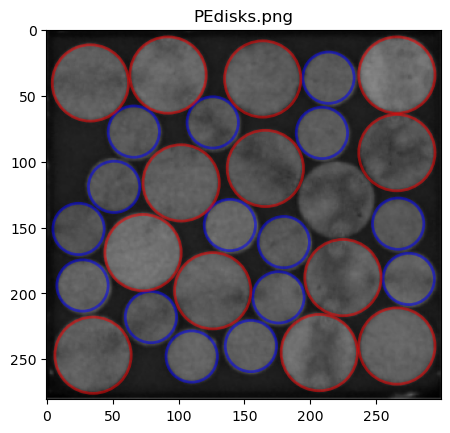

Variable *allmax* has shape (28, 2)
which means there are 28 particles
and 2 coordinates (x,y) for each particle


In [3]:
# Copy our particle-finding code from Day 3
# this is set up to work on files that look like PEdisks.png
# the code now takes the name of a file to read, as its input, instead of the data arrray

# define the kernal for circular particles
def circkernel(R, w):
    kdim = int(np.ceil(2*(float(R)+0.5)))  # +0.5 gives at least a blank pixel around the outside edge
    c = (kdim-1)/2.0  # +/- pixels from center to edge of kernal
    kernel = np.zeros((kdim, kdim))
    x, y = np.indices((kdim, kdim))
    kernel = ((x-c)**2 + (y-c)**2 < R**2 ) &  ((x-c)**2 + (y-c)**2 > (R-w)**2 )
    return(kernel - np.mean(kernel), c)   # return kernal with zero mean, and +/- size of kernel

def convcirc(imagename, R, w, thresh):
    img = skimage.io.imread(imagename)
    image = img_as_ubyte(img[:,:,2]).astype(float)
    erodedimage = skimage.morphology.erosion(image)
    # subtract to see a rim 
    image = image - erodedimage 
    # set zero mean and max=1
    image = image - np.mean(image)
    image = image/np.max(image)
    ckern, x = circkernel(R, w)
    conv = ndimage.convolve(image, ckern, mode='constant', cval=0.0)
    conv = conv/np.max(conv)
    max = peak_local_max(conv, min_distance=int(np.ceil(R)), threshold_abs = thresh)
    return(max)


filename = 'PEdisks.png'
w=1.5
Rs = 19.5
maxS = convcirc(filename, Rs, w, 0.55)
Rl = 29.0
maxL = convcirc(filename, Rl, w, 0.55)

f, ax0 = plt.subplots()#ax1.imshow(convS, cmap=plt.cm.gray)
ax0.imshow(skimage.io.imread(filename), cmap=plt.cm.gray)
for center_y, center_x in maxS:
   circle = Circle((center_x, center_y), Rs, edgecolor='blue', 
                   facecolor="none", linewidth=2, alpha=0.5)
   ax0.add_patch(circle)
for center_y, center_x in maxL:
   circle = Circle((center_x, center_y), Rl, edgecolor='red', 
                   facecolor="none", linewidth=2, alpha=0.5)
   ax0.add_patch(circle)  
plt.title(filename)
plt.show()

allmax = np.concatenate([maxS, maxL])
print('Variable *allmax* has shape', str(allmax.shape))
print('which means there are', str(allmax.shape[0]), 'particles')
print('and', str(allmax.shape[1]), 'coordinates (x,y) for each particle')

## Particle tracking (Lagrangian)

Particle tracking alogorithms typically follow the following basic steps to obtain a set of tracks $(x_i, y_i, t_i)$ for the $i^{th}$ particle:
* locate the centroids of all the particles in each image of a movie
* decide which particles are the same particle in adjacent movie frames
* add the particle's centroid in the new frame to the existing track for that particle
* if a particle is newly detected (enters the field of view, or becomes detectable), a new track starts
* if a particle ceases to be detected (leaves the field of view, or becomes undectedable), its track ends

The resulting tracks can be reformated as $x_i(t)$ and $y_i(t)$ for *each particle*, from which you can calculate diplacements or velocities of each vector component, for instance by finite differences or other (smoother) techniques.

The results will look something like this, where each different color is different particle $i$:

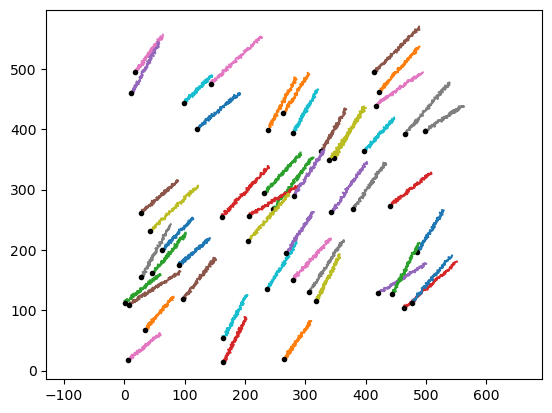

In [4]:
T = 100; t = np.arange(T)  #number of frames
L = 500   #image size
maxv = (L/T)/10  # set a reasonable velocity scale
for i in range(50):
    r = random.rand(2)*L # synthetic data, particle position vector
    v = maxv * (random.rand(2)+0.7) # synthetic data, random particle velocity vector
    vnoise = 10*maxv*random.rand(T,2) # synthetic data, noise in the measurement
    plt.plot(r[0] + t*v[0] + vnoise[:,0], r[1] + t*v[1] + vnoise[:,1])
    plt.plot(r[0], r[1], '.k')
plt.axis('equal')
plt.show()

## Digital image correlation or particle imaging velocimetry (Eulerian)

These two techniques are essentially the same, arising primarily from the solid mechanics vs. fluid mechanics communities, respectively.  They typically follow something like the following basic steps to obtain a vector field ${\vec v}(x,y)$ for each frame (time) $t$ of a movie.

* choose a window size $W$ for performing correlations between two adjacent frames $1,2$. A good starting point: $W \sim 2-3\times$ the typical distance the particles move between frames, so they don't leave the box
* perform a cross-correlation between the window $I_1(x,y)$ in the first frames, and the same window location and $I_2(x,y)$ in the next frame.
$$ C(\Delta x, \Delta y) = \frac{ \langle I_1(x,y) I_2(x + \Delta x,y + \Delta y) \rangle_{x,y} }{\langle I_1(x,y) I_2(x,y) \rangle_{x,y}} $$
where $(\Delta x, \Delta y)$ shift by up to $W/2$

* The location of the peak value $C(\Delta x, \Delta y)$ is the displacement vector (be sure to fit to get sub-pixel resolution)
* repeat over a whole grid of window-locations, to create the vector field for this pair of frames
* repeat for all pairs of adjacent frames

The results will look something like this, where each arrow is the displacement vector measured for that window:

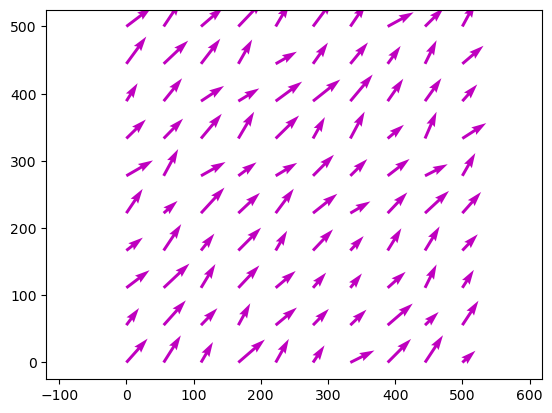

In [5]:
N = 10  #N x N grid of windows
x = np.outer(np.linspace(0, L, N),np.ones(N))
y = np.transpose(x)
u = maxv * (random.rand(N,N)+0.7) # synthetic data, x-component of displacement
v = maxv * (random.rand(N,N)+0.7) # synthetic data, y-component of displacement
plt.quiver(x, y, u, v, color='m')
plt.axis('equal')
plt.show()

## Reading in frames from a movie

Take a few-second movie of your phone moving past the grains of sand, and save it into the directory where this notebooks is saved. If you name it `movesand.mp4` then these commands will work (or you can change the filename in the notebook).

Here is some information about the various ways to read movies into python: https://scikit-image.org/docs/stable/user_guide/video.html 

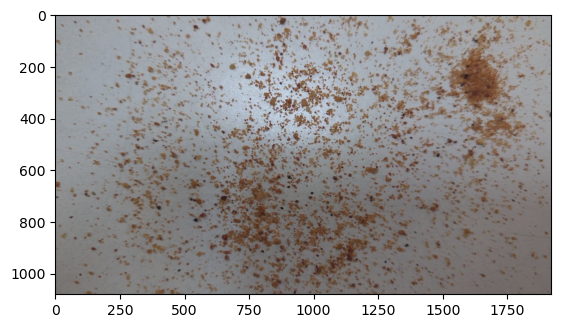

In [15]:
# if you have imageio-ffmpeg installed, this will work
vid = imageio.get_reader('movesand.mp4', 'ffmpeg')
image1 = vid.get_data(0)
image2 = vid.get_data(1)
plt.imshow(image2)
plt.show()

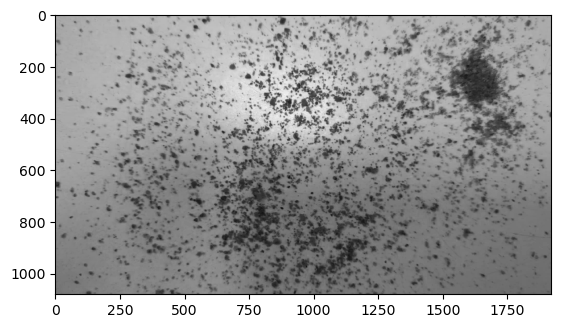

In [16]:
# if you don't have imageio-ffmpeg installed, I've saved a copy as single frames
# these were generated with the command
# ffmpeg -i "movesand.mp4" -f image2 "movesand-%04d.jpg"
# to pad the image numbers with zeros (alphabetical order = numerical order)
img = skimage.io.imread('movesand/movesand-0001.jpg')
image1 = img_as_ubyte(img[:,:,2]).astype(float)

img = skimage.io.imread('movesand/movesand-0002.jpg')
image2 = img_as_ubyte(img[:,:,2]).astype(float)

plt.imshow(image2, cmap='gray') # just the blue channel
plt.show()

## A simple DIC/PIV algorithm

The term *digital image correlation* typically refers to algorithms that are used on solid objects which have enough features on their surface (or embedded tracers of contrasting color) that these can be used to track deformation via the displacements of those features/tracers. 

The term *particle imaging velocimetry* typically refers to algorithms that are used on fluid flows which have been seeded with diluter tracers that are illuminated or fluorescent, and the velocity of these tracers is measured. 

![two similar images, and the velocity field measured between them](DIC.png)

The following is an example of a DIC/PIV algoritm to find the displacement/velocity field between the first two frames of the movie. 

First, let's compare the same window in two adjacent frames.

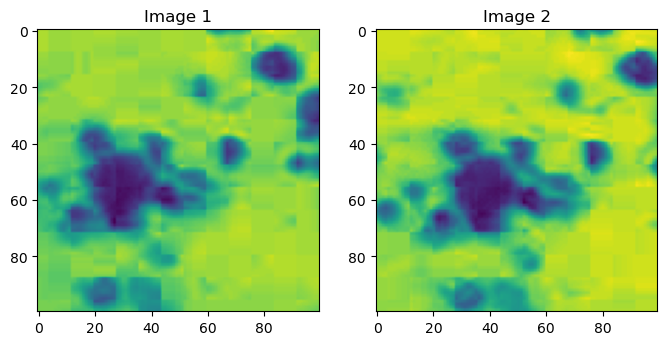

In [17]:
# compare the same window in two adjacent images
W = 100  # width of the window to correlate

# coordinate to start the window
i = 600
j = 500

im1 = image1[i:i+W, j:j+W]
im2 = image2[i:i+W, j:j+W]
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))
ax0.imshow(im1)
ax0.set_title('Image 1')
ax1.imshow(im2)
ax1.set_title('Image 2')
plt.show()

**Observe: about how far did the image move?**

$ \Delta x \sim $ ???

$ \Delta y \sim $ ???

Now, we will perform a cross-correlation of these two images, and find the largest peak. Use interactive mode to zoom in on the yellow peak and check that the displacement vector makes sense to you.

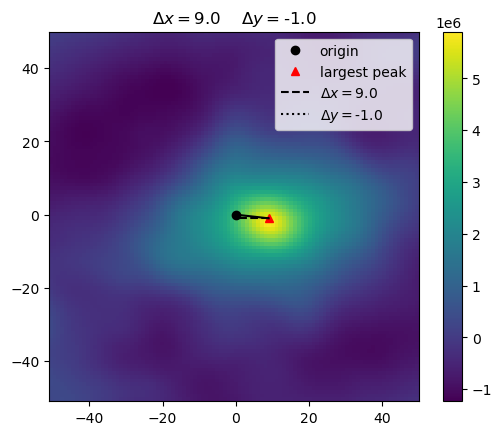

In [18]:
im1 = im1 - np.mean(im1)
im2 = im2 - np.mean(im2)

# this will pad the outside of the 2nd image with constant zeros
conv = ndimage.correlate(im2, im1, mode='constant', cval=0.0)
# the result has the same dimensions

# take the largest (#1) peak
max = peak_local_max(conv, num_peaks=1)
deltax = max[0][1] - W/2
deltay = W/2 - max[0][0]
# this should be improved to get sub-pixel resolution

plt.imshow(conv, extent=[-W/2 -1, W/2, -W/2 -1, W/2])
plt.plot(0, 0, 'ko', label='origin')
plt.plot(deltax, deltay, '^r', label='largest peak')
plt.plot([0, deltax], [0, deltay], '-k')
plt.plot([deltax, 0], [deltay, deltay], '--k', label='${\Delta}x = $'+str(deltax))
plt.plot([0, 0], [0, deltay], ':k', label='${\Delta}y = $'+str(deltay))
plt.colorbar()
plt.legend()
plt.title('${\Delta}x = $'+str(deltax)+'    ${\Delta}y = $'+str(deltay))
plt.show()

Compare this $(\Delta x, \Delta y)$ to the two images above: `im2` is moved in the $+{\hat x}$ direction relative to `im1` (velocity is to the right). 

In order to assign a velocity, we write $u = \Delta x / \Delta t$ and $v = \Delta y / \Delta t$, where the frame rate of the camera sets $\Delta t$

In [19]:
fps = 30  #frame rate, in frames per second
deltat = 1/fps
u = deltax/deltat
v = deltay/deltat
print('Velocity at pixel (' + str(i) + ','+ str(j) + ') is (' + str(u) + ',' + str(v) + ') pix/sec' )

Velocity at pixel (600,500) is (270.0,-30.0) pix/sec


Now we are ready to write a loop that puts these part together to make the whole velocity field.

In [20]:
def vfield(image1, image2, W, deltat):
    Lx = image1.shape[1] - W - 1 # columns, can't get too close to edge
    Ly = image1.shape[0] - W - 1 # rows, can't get too close to edge

    x = [] # initialize variables to store the vector field
    y = []
    u = []
    v = []
    
    # there's no reason that W has to be both the window size and the spacing
    # between measurements: I picked W*3 here
    for i in np.arange(0, Ly, W*3):   
        for j in np.arange(0, Lx, W*3): 
            # make our two windows
            im1 = image1[i:i+W, j:j+W]
            im1 = im1 - np.mean(im1)
            im2 = image2[i:i+W, j:j+W]
            im2 = im2 - np.mean(im2)
            # find the displacement that gives the peak correlation
            conv = ndimage.correlate(im2, im1, mode='constant', cval=0.0)
            disp = peak_local_max(conv, num_peaks=1)
            # this should be improved to get sub-pixel resolution
            deltax =  disp[0][1] - W/2 
            deltay = W/2 - disp[0][0]
            x.append(j)
            y.append(i)
            u.append(deltax/deltat)
            v.append(deltay/deltat)
    return(x, y, u, v)

W = 50
fps = 30
x, y, u, v  = vfield(image1, image2, W, 1/fps)

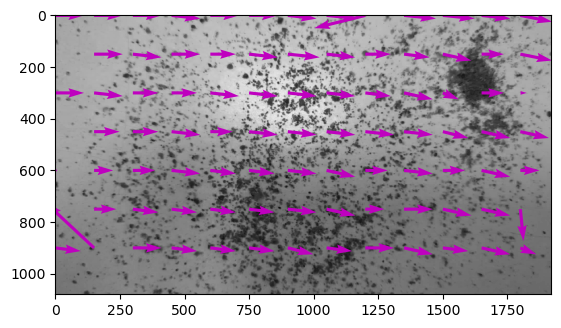

In [21]:
plt.imshow(image1, cmap = 'gray')
plt.quiver(x,y,u,v, color='m')
plt.show()

**Observe: what do you notice abouce the results? Aspects you trust, aspects you don't?** 

*record your ideas here ...*

### Repeat on your own movie

Pick one of these two methods to input your own movie/images (delete the one you're not using). Use the images to guide your choice of `W`, and be sure to set `fps` to be whatever is correct for your data.

In [13]:
# if you have imageio-ffmpeg installed, this will work
vid = imageio.get_reader('yourmovie.mp4', 'ffmpeg')
image1 = vid.get_data(0)
image2 = vid.get_data(1)
plt.imshow(image2)
plt.show()

# if you don't have imageio-ffmpeg installed, I've saved a copy as single frames
# these were generated with the command
# ffmpeg -i "movesand.mp4" -f image2 "movesand-%04d.jpg"
# to pad the image numbers with zeros (alphabetical order = numerical order)
img = skimage.io.imread('yourmovie-0001.jpg')
image1 = img_as_ubyte(img[:,:,2]).astype(float)

img = skimage.io.imread('yourmovie-0002.jpg')
image2 = img_as_ubyte(img[:,:,2]).astype(float)

plt.imshow(image2, cmap='gray') # just the blue channel
plt.show()

FileNotFoundError: No such file: '/home/kdaniel/Dropbox/Work/teaching/granular-imaging/Day4-displacements/yourmovie.mp4'

In [ ]:
# copy the velfield() and plotting codes from above to see the result:

W = 
fps = 

## A simple particle tracking algorithm

The term *particle tracking velocimetry* typically refers to algorithms that depend on first having detected all particles in a granular/colloidal flow, which are then strung onto trajectories like beads on a thread. 

We will start from the point of having already located our particle centroids ($x_i, y_i, t_i$) and wish to string them into paricle tracks. 

### Obtaining an openly-available data set

We will use the dataset from which gave rise to the image `PEdisks.png`: https://doi.org/10.1039/c8sm01372a, for whihch the particle positions are published on DataDryad: https://datadryad.org/stash/dataset/doi:10.5061/dryad.fs8sb1g 

Please download the dataset from the upper right of the Dryad webpage, and unzip the files that are part of `29Particles_Run1`. From the README we learn:

```
*centers.txt files:
 - contain information on the particles
 - one file per cycle, consecutively numbered
 - each particle correspond to one row of data
 - 1st column is particle ID, ID is consistent for all frames of one cycle
 - 2nd column is particle x-position
 - 3rd column is particle y-position
 - 4th column is particle radius
 - dimensions are in arbitrary units but consistent for each data set
```

The next code reads in the datafiles from the run named `Step05`, assuming that you have unzipped the files into this same directory this notebook is stored in. Note that all of the files we're interested in have the form `Step05-0140_centers.txt`, so we can read them all in using a for loop.

Reading 29Particles_Run1/Step05-0087_centers.txt
Found an array with shape (29, 4)


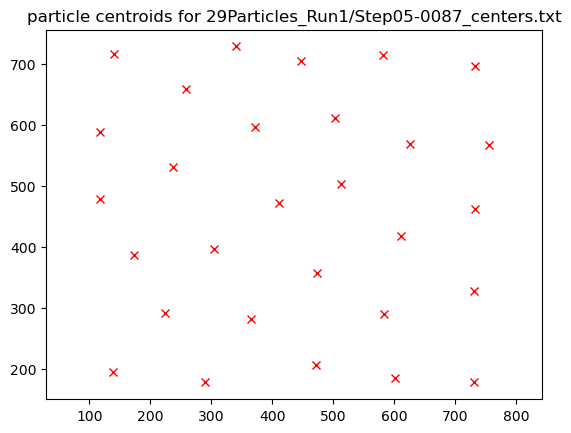

In [22]:
dirname = '29Particles_Run1'
stepname = 'Step05'
suffix = 'centers.txt'

i = 87
filename = dirname + '/' + stepname + '-' + str(i+10000)[1:] + '_' + suffix
print('Reading ' + filename)

a = np.genfromtxt(filename, delimiter=',')
print('Found an array with shape ' + str(a.shape))

plt.plot(a[:,1], a[:,2], 'xr')
plt.title('particle centroids for '+ filename)
plt.axis('equal')
plt.show()

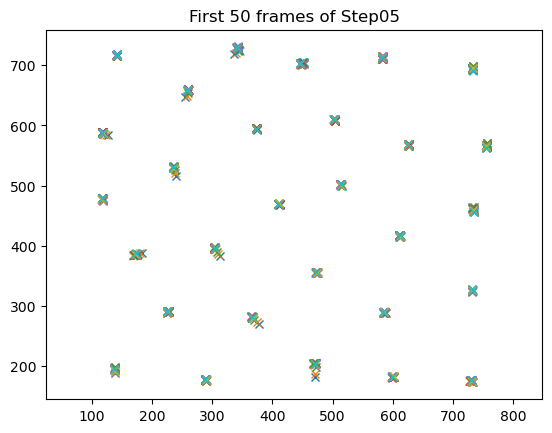

In [23]:
# this codes puts the first T of these frames/times/files into 
# two numpy arrays with the format 
#      x[3, 15] is the x coordinate of the 3rd particle found in frame 15
#      y[3, 15] is the y coordinate of the 3rd particle found in frame 15
#      R[3, 15] is the particle radius of the 3rd particle found in frame 15

T = 50
N = 29 # number of particles (easy here, since this dataset has a fixed number of particles)
x = np.zeros((N, T), dtype=float)
y = np.zeros((N, T), dtype=float)
R = np.zeros((N, T), dtype=float)
for i in np.arange(1,T+1):
    filename = dirname + '/' + stepname + '-' + str(i+10000)[1:] + '_' + suffix
    #print('Reading ' + filename)
    a = np.genfromtxt(filename, delimiter=',')
    #print('Found an array with shape ' + str(a.shape))
    x[:,i-1] = a[:,1]
    y[:,i-1] = a[:,2]
    R[:,i-1] = a[:,3]

#check that we got particles that each moved a little
plt.plot(x, y, 'x')
plt.title('First '+  str(T) +  ' frames of '+ stepname)
plt.axis('equal')
plt.show()

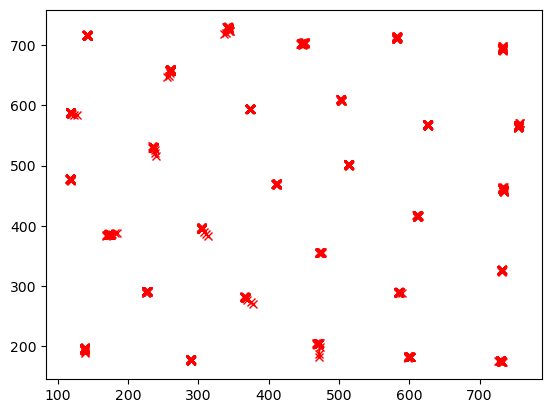

In [24]:
# make a data structure that has the following format
# px[3, 15] = x coordinate of particle named #3 at frame 15
# py[3, 15] = x coordinate of particle named #3 at frame 15

px = np.zeros((N, T), dtype=float)
py = np.zeros((N, T), dtype=float)
# so we can well when cells haven't been assigned
px[:,:] = np.NaN 
py[:,:] = np.NaN 

#give each particle in the first frame a name, putting it into px, py
px[:,0] = x[:,0]
py[:,0] = y[:,0]

for t in np.arange(1,T):  # compare each frame to the one before t-1
    #print('doing frame ' + str(t))
    for n in np.arange(N): # go through all particles in previous frame
        dx = x[:,t] - px[n,t-1] # how far particles are from #n in previous frame 
        dy = y[:,t] - py[n,t-1]
        r = dx**2 + dy**2
        m = np.argmin(r)  # this is the particle number in the previous frame that was closest
        
        # where to add screenings to get rid of false-positives
        GoodMatch = True
        
        if GoodMatch:
            px[n,t] = x[m,t]
            py[n,t] = y[m,t]
    

# look at the particle trajectories
for n in np.arange(N):
    plt.plot(px[n, :], py[n,:], 'rx-')
plt.show()

### Improving the algorithm

I selected this dataset because this simple critera was enough to achieve excellent tracking. In reality, you will likely need to add some criteria to the variable `GoodMatch` above. For instance:

* check that displaement is reasonable, e.g. `np.min(r) < 100 `
* check that  the particles `[n,t-1]` and `[m, t]` have the same radius
* check that the nearest-particle match is made going BOTH the forward-time and backward-time direction
* ... what else?

### Calculating velocities and higher momements 

Zoom in on each particle, and you'll see that now the positions are all strung together into a single trajectory. This means we can examine each one to find its Lagrangian velocity. 

Use the following code to examine a few of the particles.

*Note:* this data was actually collected stroboscopically (at a fixed phase of a larger oscillatory motion), so the measurements we make are not true kinematics. But they work here for a pedagogical exercise.

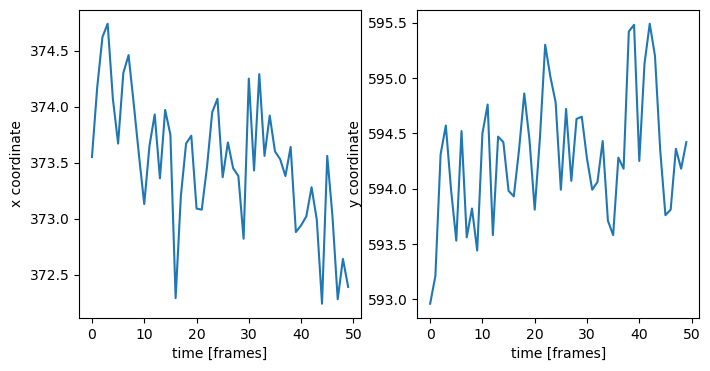

In [25]:
n = 12 #look at this particle only
fps = 1 #these images aren't really time, just frames
t = np.arange(0,T)/fps 

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))

ax0.plot(t, px[n,:])
ax0.set_xlabel('time [frames]')
ax0.set_ylabel('x coordinate')
ax1.plot(t, py[n,:])
ax1.set_xlabel('time [frames]')
ax1.set_ylabel('y coordinate')
plt.show()

This data is noisy (by design, for reasons described in the original paper), and these jumps actually correspond to variations in the position of each particles within the "cage" made by its neighbors. 

For the purposes of understanding particle tracking velocimetrys, we can calculate each particles's velocity from one frame to the next, as a finite differences:

$$ u = \Delta x / \Delta t$$
$$ v = \Delta y / \Delta t$$

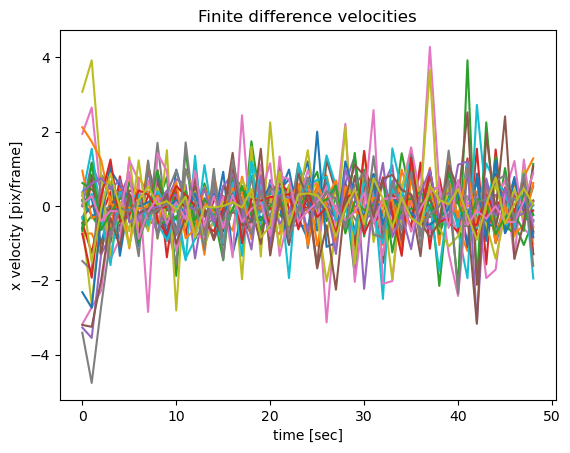

In [26]:
u = np.zeros((N, T-1), dtype=float)
v = np.zeros((N, T-1), dtype=float)

for n in np.arange(N):
    u[n,:] = (px[n, 1:] - px[n,0:-1])/fps
    v[n,:] = (py[n, 1:] - py[n,0:-1])/fps
    # a fancier version could do a local fit to get a slope of x(t) and y(t)

plt.plot(t[0:-1], np.transpose(u))
plt.xlabel('time [sec]')
plt.ylabel('x velocity [pix/frame]')
plt.title('Finite difference velocities')
plt.show()

Having the individual, Langrangian, velocity components also lets us calculate the granular temperature:

$$T_g = \frac{1}{2}\langle u - {\bar u} \rangle^2 + \frac{1}{2}\langle v - {\bar v} \rangle^2 $$

and examine histograms of the velocity (displacement) measurements to see whether they are Gaussian-distributed. See the Xu/Reeves/Louge paper listed in the addition reading section below, for more on the perils of performing such calcuations. 

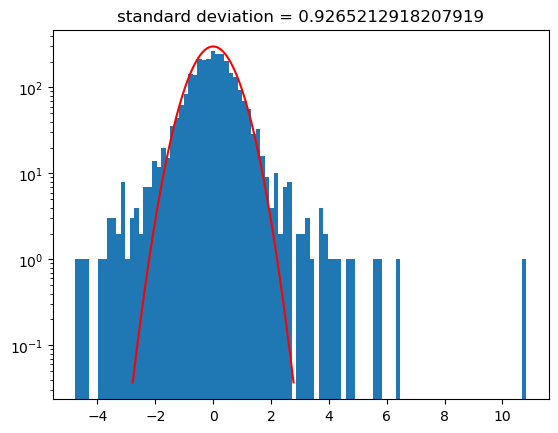

In [27]:
vels = np.concatenate((u,v))
vels = np.reshape(vels, (vels.size,1))
sigma = np.std(vels)

vbins = np.linspace(-3*sigma, 3*sigma, 100)
plt.hist(vels, vbins.size)
plt.plot(vbins, 300*np.exp(-(vbins/sigma)**2), 'r-')
plt.yscale('log')
plt.title('standard deviation = ' + str(sigma))
plt.show()

# Post-class

## Every week

If you and your group worked together on a single notebook, don't forget to email each other a copy of the final version.

Please feel free to complete any parts you didn't finish, and ask questions at the start of the next class.

## Additional resources

Journal article PDFs are saved in the `Readings` folder on Google Drive

### Particle tracking (Lagrangian) 

Published codes:
* https://soft-matter.github.io/trackpy/v0.5.0/  (python)
* https://site.physics.georgetown.edu/matlab/ (matlab)
* https://github.com/rplab/TrackingGUI_and_Localization_Public (matlab) 

Readings:
* Crocker, J. C., & Grier, D. G. (1996). Methods of Digital Video Microscopy for Colloidal Studies. *Journal of Colloid and Interface Science* 179: 298–310. https://doi.org/10.1006/jcis.1996.0217
* Xu, H., Reeves, A. P., & Louge, M. Y. (2004). Measurement errors in the mean and fluctuation velocities of spherical grains from a computer analysis of digital images. *Review of Scientific Instruments* 75: 811–819. https://doi.org/10.1063/1.1666989 

### Digital image correlation / Particle imaging velocimetry (Eulerian)

Published codes:
* https://mudic.readthedocs.io/ (python)
* https://www.spam-project.dev/ (python)
* https://in.mathworks.com/matlabcentral/fileexchange/12413-digital-image-correlation-and-tracking (matlab)
* https://www.ncorr.com/ (plugin for matlab) 

Readings:
* Markus Raffel, Christian E. Willert, Steve T. Wereley, Jürgen Kompenhans. Particle Image Velocimetry: A Practical Guide, Second Edition. Springer-Verlag (2007) https://doi.org/10.1007/978-3-540-72308-0 
* J Westerweel. “Fundamentals of digital particle image velocimetry”  *Measurement Science and Technology* 8: 1379 (1997) https://doi.org/10.1088/0957-0233/8/12/002
* M. Bornert, et al. “Assessment of Digital Image Correlation Measurement Errors: Methodology and Results”  *Experimental Mechanics* (2009) 49:353–370 https://doi.org/10.1007/s11340-008-9204-7  